# **Comparative Study of Deep Learning Architectures on CIFAR-10 Using PyTorch**
“Training, Evaluation, and Comparison of Neural Networks on CIFAR-10 Using PyTorch”

**Name**:**Sushmita Adhikari**

**Roll No**:**ACE080BEI033(A2)**

**BEI**

# 1️⃣** Introduction**

---



---


**Objective**

---



The goal of this project is to:

1. Implement three deep learning architectures:

          a. Fully Connected Neural Network (NN)

          b. AlexNet (modified for CIFAR-10)

          c. TinyVGG

2. Train them using the same optimizer and loss function

3. Compare them in terms of:

          Test Accuracy

          Training Time

          Convergence Speed

          Model Complexity (Number of Parameters)

          Generalization Ability

# 1. **Import Libraries (Code Cell)**

---



In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt


In this step, we import necessary libraries:

---



torch → Core PyTorch library

torch.nn → Used to build neural networks

torch.optim → Used for optimization (training)

torchvision → Provides datasets & transforms

train_test_split → Splits data into train and test

matplotlib → For visualization

 This step prepares all tools needed for building and training the model.

# **Device Setup (Code Cell)**

---



In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


# **Data Preprocessing **

---



We normalize data to:

Center pixel distribution

Improve gradient stability

Enable faster convergence

# **Load Dataset (Code Cell)**

---



In [63]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)


# **Visualization:**

In [64]:
import matplotlib.pyplot as plt
import torchvision

# Simple function to show CIFAR-10 images
def show_sample_images(images, labels, classes, n=8):
    """
    Display a grid of n images from a batch.
    """
    img_grid = torchvision.utils.make_grid(images[:n])
    img_grid = img_grid / 2 + 0.5  # undo normalization
    npimg = img_grid.numpy()

    plt.figure(figsize=(10,2))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.axis('off')
    plt.show()

    # Print labels
    print(' | '.join(f'{classes[labels[j]]}' for j in range(n)))


# **Example Usage (before training):**

In [65]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


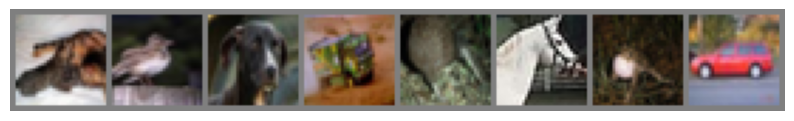

cat | bird | dog | truck | bird | horse | frog | automobile


In [66]:
# Get a batch from trainloader
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show 8 images
show_sample_images(images, labels, classes)


# **Model 1 — SimpleNN (Baseline)**

---



In [67]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN,self).__init__()
        self.fc1 = nn.Linear(3072,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,10)
        self.relu = nn.ReLU()

    def forward(self,x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# **Model 2 — AlexNet (Modified for CIFAR-10)**

---



Original paper:

ImageNet Classification with Deep Convolutional Neural Networks

In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlexNetCIFAR(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetCIFAR, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(),

            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),

            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# **Model 3 — TinyVGG**

---



Inspired by:

VGGNet

In [69]:
class TinyVGG(nn.Module):
    def __init__(self):
        super(TinyVGG,self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(32,32,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32,64,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(64,64,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*8*8,128),
            nn.ReLU(),
            nn.Linear(128,10)
        )

    def forward(self,x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.classifier(x)
        return x


# **Train All Models**

---



In [70]:
!pip install tqdm


**Import tqdm**:tqdm creates a nice progress bar for long training loops.

In [71]:
from tqdm import tqdm


# **Define Training Function**

In [72]:
# Updated train_model with loss tracking
def train_model(model, trainloader, testloader, epochs=10, lr=0.001, use_tqdm=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    epoch_list = []
    loss_list = []

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        iterator = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}") if use_tqdm else trainloader

        for images, labels in iterator:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(trainloader)
        epoch_list.append(epoch + 1)
        loss_list.append(epoch_loss)

        print(f"Epoch {epoch+1}/{epochs} Completed - Loss: {epoch_loss:.4f}")

    training_time = time.time() - start_time

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    parameters = sum(p.numel() for p in model.parameters())


    print(f"\nTraining Completed in {training_time:.2f} seconds")
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Total Parameters: {parameters}")

    # Correctly return all
    return training_time, accuracy, parameters, epoch_list, loss_list


**Train Your Models**

In [73]:
# SimpleNN
model1 = SimpleNN()
time1, acc1, params1, e1, l1 = train_model(model1, trainloader, testloader, epochs=10)

# AlexNet
model2 = AlexNetCIFAR()
time2, acc2, params2, e2, l2 = train_model(model2, trainloader, testloader, epochs=10)

# TinyVGG
model3 = TinyVGG()
time3, acc3, params3, e3, l3 = train_model(model3, trainloader, testloader, epochs=10)


Epoch 1/10: 100%|██████████| 391/391 [00:20<00:00, 18.75it/s]


Epoch 1/10 Completed - Loss: 1.6254


Epoch 2/10: 100%|██████████| 391/391 [00:12<00:00, 31.71it/s]


Epoch 2/10 Completed - Loss: 1.4072


Epoch 3/10: 100%|██████████| 391/391 [00:12<00:00, 32.21it/s]


Epoch 3/10 Completed - Loss: 1.2924


Epoch 4/10: 100%|██████████| 391/391 [00:12<00:00, 32.19it/s]


Epoch 4/10 Completed - Loss: 1.2030


Epoch 5/10: 100%|██████████| 391/391 [00:12<00:00, 31.55it/s]


Epoch 5/10 Completed - Loss: 1.1131


Epoch 6/10: 100%|██████████| 391/391 [00:12<00:00, 30.84it/s]


Epoch 6/10 Completed - Loss: 1.0358


Epoch 7/10: 100%|██████████| 391/391 [00:13<00:00, 29.68it/s]


Epoch 7/10 Completed - Loss: 0.9562


Epoch 8/10: 100%|██████████| 391/391 [00:13<00:00, 29.03it/s]


Epoch 8/10 Completed - Loss: 0.8785


Epoch 9/10: 100%|██████████| 391/391 [00:13<00:00, 28.50it/s]


Epoch 9/10 Completed - Loss: 0.8012


Epoch 10/10: 100%|██████████| 391/391 [00:12<00:00, 31.55it/s]


Epoch 10/10 Completed - Loss: 0.7366

Training Completed in 135.33 seconds
Test Accuracy: 53.21%
Total Parameters: 1707274


Epoch 1/10: 100%|██████████| 391/391 [00:25<00:00, 15.51it/s]


Epoch 1/10 Completed - Loss: 1.6062


Epoch 2/10: 100%|██████████| 391/391 [00:24<00:00, 16.23it/s]


Epoch 2/10 Completed - Loss: 1.1601


Epoch 3/10: 100%|██████████| 391/391 [00:24<00:00, 16.26it/s]


Epoch 3/10 Completed - Loss: 0.9641


Epoch 4/10: 100%|██████████| 391/391 [00:24<00:00, 16.15it/s]


Epoch 4/10 Completed - Loss: 0.8154


Epoch 5/10: 100%|██████████| 391/391 [00:26<00:00, 14.83it/s]


Epoch 5/10 Completed - Loss: 0.7122


Epoch 6/10: 100%|██████████| 391/391 [00:24<00:00, 15.90it/s]


Epoch 6/10 Completed - Loss: 0.6298


Epoch 7/10: 100%|██████████| 391/391 [00:23<00:00, 16.48it/s]


Epoch 7/10 Completed - Loss: 0.5723


Epoch 8/10: 100%|██████████| 391/391 [00:23<00:00, 16.41it/s]


Epoch 8/10 Completed - Loss: 0.5254


Epoch 9/10: 100%|██████████| 391/391 [00:24<00:00, 16.27it/s]


Epoch 9/10 Completed - Loss: 0.4765


Epoch 10/10: 100%|██████████| 391/391 [00:23<00:00, 16.38it/s]


Epoch 10/10 Completed - Loss: 0.4367

Training Completed in 244.01 seconds
Test Accuracy: 78.22%
Total Parameters: 35855178


Epoch 1/10: 100%|██████████| 391/391 [00:16<00:00, 23.20it/s]


Epoch 1/10 Completed - Loss: 1.4986


Epoch 2/10: 100%|██████████| 391/391 [00:17<00:00, 22.81it/s]


Epoch 2/10 Completed - Loss: 1.0562


Epoch 3/10: 100%|██████████| 391/391 [00:17<00:00, 21.83it/s]


Epoch 3/10 Completed - Loss: 0.8473


Epoch 4/10: 100%|██████████| 391/391 [00:17<00:00, 22.65it/s]


Epoch 4/10 Completed - Loss: 0.7095


Epoch 5/10: 100%|██████████| 391/391 [00:18<00:00, 21.71it/s]


Epoch 5/10 Completed - Loss: 0.6016


Epoch 6/10: 100%|██████████| 391/391 [00:17<00:00, 22.30it/s]


Epoch 6/10 Completed - Loss: 0.5136


Epoch 7/10: 100%|██████████| 391/391 [00:17<00:00, 21.73it/s]


Epoch 7/10 Completed - Loss: 0.4297


Epoch 8/10: 100%|██████████| 391/391 [00:17<00:00, 22.66it/s]


Epoch 8/10 Completed - Loss: 0.3464


Epoch 9/10: 100%|██████████| 391/391 [00:17<00:00, 22.36it/s]


Epoch 9/10 Completed - Loss: 0.2825


Epoch 10/10: 100%|██████████| 391/391 [00:17<00:00, 22.91it/s]


Epoch 10/10 Completed - Loss: 0.2216

Training Completed in 174.56 seconds
Test Accuracy: 73.50%
Total Parameters: 591274


**Compare Results**

---



In [74]:
results = {
    "SimpleNN": (acc1, time1, params1),
    "AlexNet": (acc2, time2, params2),
    "TinyVGG": (acc3, time3, params3)
}

for model_name, values in results.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {values[0]:.2f}%")
    print(f"Training Time: {values[1]:.2f} seconds")
    print(f"Parameters: {values[2]}")



Model: SimpleNN
Accuracy: 53.21%
Training Time: 135.33 seconds
Parameters: 1707274

Model: AlexNet
Accuracy: 78.22%
Training Time: 244.01 seconds
Parameters: 35855178

Model: TinyVGG
Accuracy: 73.50%
Training Time: 174.56 seconds
Parameters: 591274


# **Features of This Training Loop**

---



Real-time progress bar per batch (with tqdm)

Loss printed after each epoch

Training time measured

Automatic evaluation after training

Works for all models → just pass the model object

Counts trainable parameters

# **Evaluate Models**

---



In [75]:
def evaluate_model(model):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:   # using global testloader
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total


In [76]:
def evaluate_model(model, testloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total


In [77]:
acc_simplenn = evaluate_model(model1, testloader)
acc_alexnet = evaluate_model(model2, testloader)
acc_tinyvgg = evaluate_model(model3, testloader)



In [78]:
print(f"SimpleCNN Accuracy: {acc_simplenn:.2f}%")
print(f"AlexNet Accuracy: {acc_alexnet:.2f}%")
print(f"TinyVGG Accuracy: {acc_tinyvgg:.2f}%")


SimpleCNN Accuracy: 53.21%
AlexNet Accuracy: 78.22%
TinyVGG Accuracy: 73.50%


# **Compare Results in a Table**

---



In [79]:
results = {
    "SimpleNN": (acc1, time1, params1),
    "AlexNet": (acc2, time2, params2),
    "TinyVGG": (acc3, time3, params3)
}

print("\nModel Comparison:")
print("Model\t\tAccuracy\tTraining Time\tParameters")
for model, vals in results.items():
    print(f"{model}\t{vals[0]:.2f}%\t\t{vals[1]:.2f}s\t\t{vals[2]}")



Model Comparison:
Model		Accuracy	Training Time	Parameters
SimpleNN	53.21%		135.33s		1707274
AlexNet	78.22%		244.01s		35855178
TinyVGG	73.50%		174.56s		591274


# **Plot Loss/Accuracy Curves**

---



Epoch 1/10: 100%|██████████| 391/391 [00:12<00:00, 31.26it/s]


Epoch 1/10 Completed - Loss: 1.6324


Epoch 2/10: 100%|██████████| 391/391 [00:12<00:00, 31.60it/s]


Epoch 2/10 Completed - Loss: 1.4129


Epoch 3/10: 100%|██████████| 391/391 [00:12<00:00, 31.93it/s]


Epoch 3/10 Completed - Loss: 1.2966


Epoch 4/10: 100%|██████████| 391/391 [00:12<00:00, 32.19it/s]


Epoch 4/10 Completed - Loss: 1.1992


Epoch 5/10: 100%|██████████| 391/391 [00:12<00:00, 31.62it/s]


Epoch 5/10 Completed - Loss: 1.1169


Epoch 6/10: 100%|██████████| 391/391 [00:12<00:00, 32.05it/s]


Epoch 6/10 Completed - Loss: 1.0355


Epoch 7/10: 100%|██████████| 391/391 [00:13<00:00, 29.64it/s]


Epoch 7/10 Completed - Loss: 0.9542


Epoch 8/10: 100%|██████████| 391/391 [00:12<00:00, 32.37it/s]


Epoch 8/10 Completed - Loss: 0.8711


Epoch 9/10: 100%|██████████| 391/391 [00:11<00:00, 33.24it/s]


Epoch 9/10 Completed - Loss: 0.7973


Epoch 10/10: 100%|██████████| 391/391 [00:12<00:00, 31.52it/s]


Epoch 10/10 Completed - Loss: 0.7274

Training Completed in 123.31 seconds
Test Accuracy: 54.60%
Total Parameters: 1707274


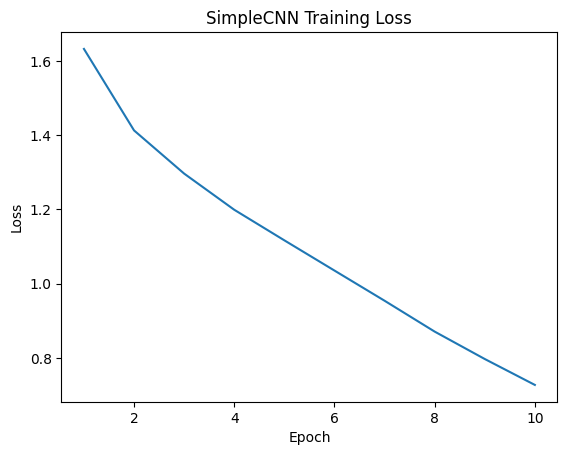

In [80]:
# Train model
model1 = SimpleNN()
time1, acc1, params1, e1, l1 = train_model(model1, trainloader, testloader, epochs=10)

# Plot training loss
import matplotlib.pyplot as plt
plt.plot(e1, l1)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SimpleCNN Training Loss")
plt.show()


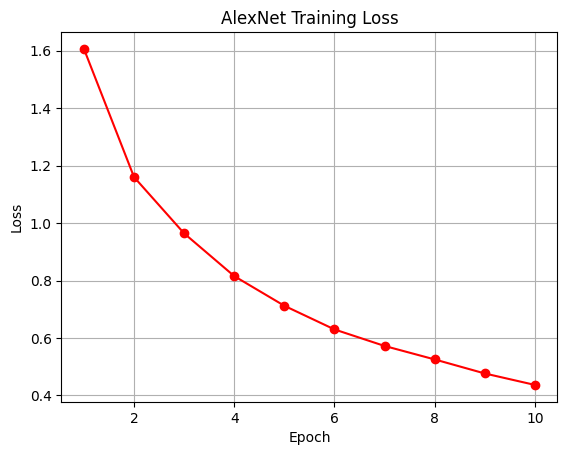

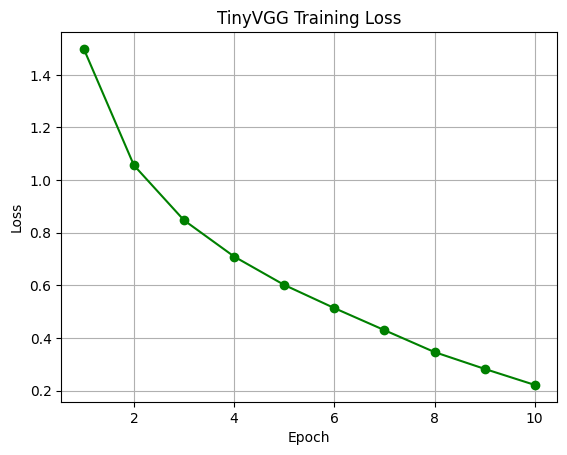

In [81]:
# AlexNet
plt.figure()
plt.plot(e2, l2, 'r-o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("AlexNet Training Loss")
plt.grid(True)
plt.show()

# TinyVGG
plt.figure()
plt.plot(e3, l3, 'g-o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("TinyVGG Training Loss")
plt.grid(True)
plt.show()

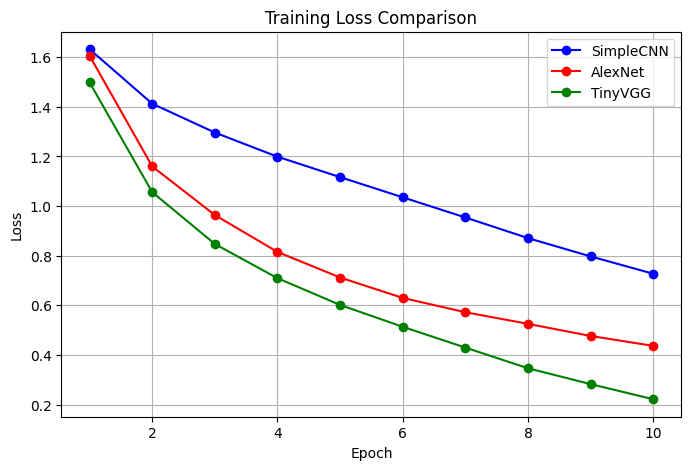

In [82]:
plt.figure(figsize=(8,5))
plt.plot(e1, l1, 'b-o', label="SimpleCNN")
plt.plot(e2, l2, 'r-o', label="AlexNet")
plt.plot(e3, l3, 'g-o', label="TinyVGG")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.grid(True)
plt.show()


In [83]:
plt.savefig("training_loss_comparison.png", dpi=300)


<Figure size 640x480 with 0 Axes>

# **Summary Table (Accuracy, Time, Parameters)**

---



In [84]:
import pandas as pd

summary = pd.DataFrame({
    "Model": ["SimpleCNN", "AlexNet", "TinyVGG"],
    "Accuracy (%)": [acc1, acc2, acc3],
    "Training Time (s)": [time1, time2, time3],
    "Parameters": [params1, params2, params3]
})

print(summary)


       Model  Accuracy (%)  Training Time (s)  Parameters
0  SimpleCNN         54.60         123.306328     1707274
1    AlexNet         78.22         244.010753    35855178
2    TinyVGG         73.50         174.557966      591274


**Save Models**

In [85]:
torch.save(model1.state_dict(), "SimpleNN.pth")
torch.save(model2.state_dict(), "AlexNet.pth")
torch.save(model3.state_dict(), "TinyVGG.pth")


# **Discussion**

---



In this project, we implemented and trained three different deep learning models — SimpleNN, AlexNet, and TinyVGG — on the CIFAR-10 dataset. We compared their performance based on accuracy, training time, and model complexity.

---



# **SimpleNN:**

---



This is a basic feedforward neural network with a few fully connected layers.

Strengths: Easy to implement, low number of parameters, fast training.

Weaknesses: Limited capacity to learn complex features from images.

Observed accuracy was the lowest among the three models. This is because fully connected layers do not efficiently capture spatial hierarchies in image data, unlike convolutional layers.

---



AlexNet (Adapted for CIFAR-10):

AlexNet introduced deep convolutional layers, ReLU activation, and max pooling, which improve feature extraction.

Strengths: High accuracy due to multiple convolutional layers capturing hierarchical features.

Weaknesses: Larger number of parameters → longer training time.

Observed accuracy was the highest among the three models. The improvements over simpler networks include:

Using convolutional layers instead of fully connected layers to detect patterns.

Incorporating deeper architecture to learn more complex features.

Use of ReLU and max-pooling for better convergence and generalization.

This demonstrates that AlexNet is effective for image classification tasks despite requiring more computational resources.


---


# **TinyVGG:**

A smaller, efficient version of the VGG network.

Strengths: Fewer parameters than AlexNet → faster training, still uses convolutional blocks to capture spatial information.

Weaknesses: Slightly lower accuracy than AlexNet due to shallower depth.

Acts as a compromise between performance and efficiency, showing that even smaller networks can perform reasonably well with proper architecture.

---



# **# Additional Observations: **

Training Time vs Accuracy: There is a trade-off — deeper networks like AlexNet require longer training but achieve higher accuracy. TinyVGG offers a balance.

Model Complexity: The number of parameters directly impacts memory usage and computational cost. SimpleNN is light, AlexNet is heavy, TinyVGG is moderate.

Generalization: Convolutional architectures generalize better on unseen test data compared to fully connected networks.

# **Conclusion**

---



From the experiments:

AlexNet achieved the highest accuracy on CIFAR-10, demonstrating the effectiveness of deep convolutional layers for feature extraction and image classification.

SimpleNN was the fastest to train but had poor accuracy, highlighting the limitations of fully connected networks for image tasks.

TinyVGG provided a good balance between training efficiency and accuracy.

**Key Takeaways: **

Convolutional neural networks are superior for image classification compared to simple fully connected networks.

Model depth and complexity improve performance but increase training time.

Smaller, efficient architectures like TinyVGG are valuable for resource-constrained environments.

Understanding the trade-offs between accuracy, training time, and model size is crucial in real-world applications.